# Prédiction Ligue 1 (2023) — Notebook

Objectif : construire un pipeline reproductible et mieux justifié (visualisations, anti-fuite de données, features additionnelles) pour prédire le résultat des matchs 2023 (-1, 0, 1)

Plan rapide :
- Chargement & aperçu des données + visualisations pour motiver les choix de nettoyage.
- Préparation : gestion des dates, valeurs manquantes, suppression des fuites (buts, formations, managers...).
- Enrichissement : valeur de marché agrégée, capacité stade, forme récente (rolling points), ratio/log de valeurs.
- Modèles : logreg pondérée, RandomForest ; comparaison par F1-macro + matrice de confusion.
- Export des prédictions `predictions_2023.csv` au format attendu.


In [80]:
# Imports & configuration
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# XGBoost (si disponible, sinon on utilisera GradientBoostingClassifier de sklearn)
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    from sklearn.ensemble import GradientBoostingClassifier
    XGBOOST_AVAILABLE = False
    print("XGBoost non disponible, utilisation de GradientBoostingClassifier de sklearn")

sns.set_theme(style="whitegrid")
np.random.seed(42)

# Création du dossier pour sauvegarder les images
IMAGES_DIR = Path('images')
IMAGES_DIR.mkdir(exist_ok=True)
print(f"Dossier images créé : {IMAGES_DIR.absolute()}")



XGBoost non disponible, utilisation de GradientBoostingClassifier de sklearn
Dossier images créé : /Users/omarelbarbari/Downloads/Fichier_Projet_Foot copie/images


In [81]:
# Chargement des données
DATA_DIR = Path('.')

match_history = pd.read_csv(DATA_DIR / 'matchs_2013_2022.csv')
match_predict = pd.read_csv(DATA_DIR / 'match_2023.csv')
player_app = pd.read_csv(DATA_DIR / 'player_appearance.csv')
player_val = pd.read_csv(DATA_DIR / 'player_valuation_before_season.csv')
clubs = pd.read_csv(DATA_DIR / 'clubs_fr.csv')
events = pd.read_csv(DATA_DIR / 'game_events.csv')

print("Loaded:")
for name, df in {
    "match_history": match_history,
    "match_predict": match_predict,
    "player_app": player_app,
    "player_val": player_val,
    "clubs": clubs,
    "events": events,
}.items():
    print(f"- {name:15s}: {df.shape}")


Loaded:
- match_history  : (4078, 23)
- match_predict  : (270, 12)
- player_app     : (115182, 13)
- player_val     : (30215, 5)
- clubs          : (35, 13)
- events         : (40995, 11)


## Aperçu des données

On regarde les colonnes cibles et la balance des classes pour motiver le choix des métriques pondérées.


   results
0        0
1       -1
2       -1
3        0
4        1


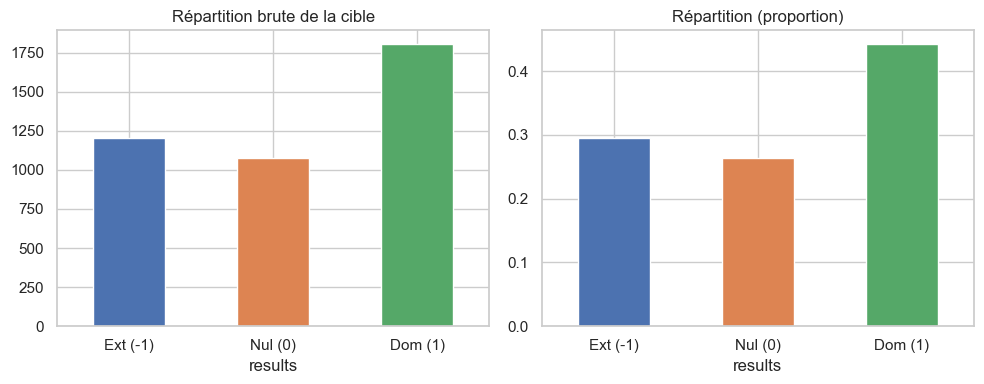

In [82]:
# Distribution de la cible et aperçu des colonnes
print(match_history[['results']].head())

fig, ax = plt.subplots(1,2, figsize=(10,4))
match_history['results'].value_counts().sort_index().plot(kind='bar', ax=ax[0], color=['C0','C1','C2'])
ax[0].set_title('Répartition brute de la cible')
ax[0].set_xticklabels(['Ext (-1)','Nul (0)','Dom (1)'], rotation=0)

match_history['results'].value_counts(normalize=True).sort_index().plot(kind='bar', ax=ax[1], color=['C0','C1','C2'])
ax[1].set_title('Répartition (proportion)')
ax[1].set_xticklabels(['Ext (-1)','Nul (0)','Dom (1)'], rotation=0)
plt.tight_layout()
plt.savefig(IMAGES_DIR / '01_distribution_cible.png', dpi=300, bbox_inches='tight')
plt.show()



Taux de valeurs manquantes :
 home_club_formation    0.093673
away_club_formation    0.093673
attendance             0.082639
home_club_position     0.000000
away_club_position     0.000000
dtype: float64


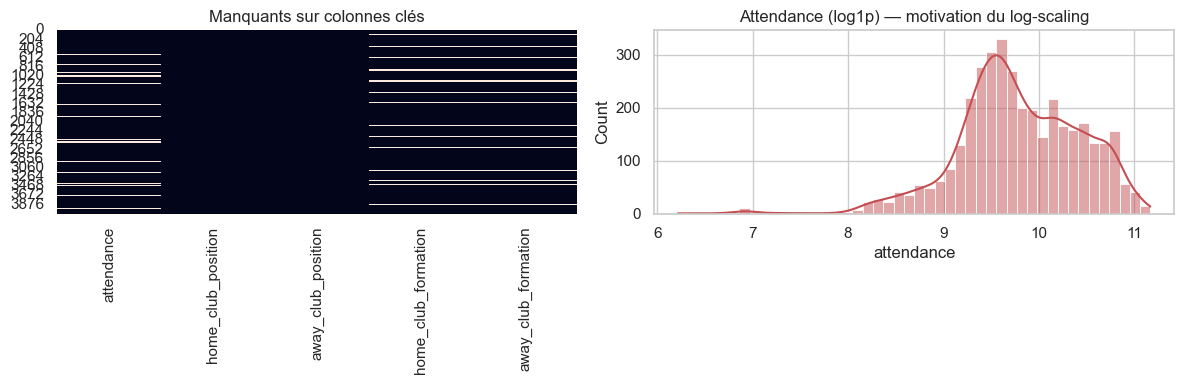

In [83]:
# Valeurs manquantes clés + distribution d'affluence (log)
cols_focus = ['attendance', 'home_club_position', 'away_club_position', 'home_club_formation', 'away_club_formation']
missing = match_history[cols_focus].isna().mean().sort_values(ascending=False)
print("Taux de valeurs manquantes :\n", missing)

fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.heatmap(match_history[cols_focus].isna(), cbar=False, ax=ax[0])
ax[0].set_title('Manquants sur colonnes clés')

sns.histplot(np.log1p(match_history['attendance']), kde=True, ax=ax[1], color='C3')
ax[1].set_title('Attendance (log1p) — motivation du log-scaling')
plt.tight_layout()
plt.savefig(IMAGES_DIR / '02_valeurs_manquantes_attendance.png', dpi=300, bbox_inches='tight')
plt.show()



## Préparation des données (anti-fuite)

Principes :
- Supprimer les colonnes dépendantes du résultat (buts, formations, managers) pour éviter la fuite.
- Imputer `attendance` par la médiane (voir distribution ci-dessus) et travailler en log pour réduire la skewness.
- Harmoniser la saison sur les matchs à prédire (2023).
- Garder des identifiants pour joindre des features équipes/joueurs.


In [84]:
# Nettoyage des matchs
matches_train = match_history.copy()
matches_pred = match_predict.copy()

# Dates
matches_train['date'] = pd.to_datetime(matches_train['date'])
matches_pred['date'] = pd.to_datetime(matches_pred['date'])

# Saison pour les matchs à prédire
matches_pred['season'] = 2023

# Imputation attendance (médiane) et log transform
attendance_median = matches_train['attendance'].median()
for df in (matches_train, matches_pred):
    df['attendance'] = df['attendance'].fillna(attendance_median)
    df['attendance_log'] = np.log1p(df['attendance'])

# Colonnes à supprimer (fuite ou trop textuelles)
cols_leak = [
    'Unnamed: 0', 'home_club_goals', 'away_club_goals',
    'home_club_position', 'away_club_position',
    'round', 'aggregate', 'home_club_manager_name', 'away_club_manager_name',
    'stadium', 'referee', 'home_club_name', 'away_club_name',
    'competition_type', 'home_club_formation', 'away_club_formation'
]
matches_train = matches_train.drop(columns=cols_leak, errors='ignore')
matches_pred = matches_pred.drop(columns=cols_leak, errors='ignore')

print("Colonnes entraînement:", matches_train.columns.tolist())


Colonnes entraînement: ['game_id', 'season', 'date', 'home_club_id', 'away_club_id', 'attendance', 'results', 'attendance_log']


### Features joueurs & valeur de marché

- On conserve les apparitions avec minutes > 0 et on dérive la saison (année, décalée pour août).
- On garde la dernière valeur par joueur et saison pour éviter de moyenner sur plusieurs dates.
- Agrégation par club et match : moyenne de valeur de marché (proxy de la force de l’effectif aligné).


In [85]:
# Apparitions filtrées
app = player_app[['game_id','player_id','player_club_id','date','minutes_played','yellow_cards','red_cards']].copy()
app['date'] = pd.to_datetime(app['date'])
app['season'] = app['date'].apply(lambda d: d.year if d.month >= 8 else d.year - 1)
app = app[app['minutes_played'] > 0]

# Valeurs marchandes : dernière valeur par joueur/saison
val = player_val[['player_id','date','market_value_in_eur']].copy()
val['date'] = pd.to_datetime(val['date'])
val['season'] = val['date'].dt.year
val = val.sort_values('date').drop_duplicates(subset=['player_id','season'], keep='last')
val = val[['player_id','season','market_value_in_eur']]

# Fusion apparitions + valeur
app_val = app.merge(val, on=['player_id','season'], how='left')
app_val['market_value_in_eur'] = app_val['market_value_in_eur'].fillna(0)

team_value = (
    app_val.groupby(['game_id','player_club_id'])['market_value_in_eur']
    .mean()
    .reset_index()
    .rename(columns={'player_club_id':'club_id', 'market_value_in_eur':'team_avg_value'})
)

print("Team value shape:", team_value.shape)
team_value.head()



Team value shape: (8156, 3)


,game_id,club_id,team_avg_value
0,2223841,1423,8.750000e+05
1,2223841,3911,1.500000e+06
2,2223842,1147,6.923077e+05
3,2223842,3911,1.428571e+06
4,2223843,1159,4.583333e+05


### Features événements

On dérive des compteurs simples (jaunes, rouges, buts) par club et match. Ils seront utilisées seulement comme historique agrégé (pas les buts du match courant dans le jeu de features pour éviter la fuite).


In [86]:
events_sub = events[['game_id','club_id','type','description']].copy()
events_sub['jaune'] = events_sub['description'].str.contains('Yellow', na=False).astype(int)
events_sub['rouge'] = events_sub['description'].str.contains('Red', na=False).astype(int)
events_sub['but'] = (events_sub['type'] == 'Goals').astype(int)

events_team = (
    events_sub.groupby(['game_id','club_id'])[['jaune','rouge','but']]
    .sum()
    .reset_index()
    .rename(columns={'but':'goals_events'})
)

events_team.head()



,game_id,club_id,jaune,rouge,goals_events
0,2223841,1423,2,1,1
1,2223841,3911,2,0,2
2,2223842,1147,1,0,1
3,2223842,3911,2,0,0
4,2223843,1159,1,0,0


### Forme récente (points roulants)

Pour capter le contexte récent sans fuite :
- On convertit chaque match en deux lignes club (domicile et extérieur) avec points (3/1/0) et date.
- On ordonne chronologiquement et on calcule la moyenne des points sur les 5 derniers matchs (`rolling_mean`, avec `shift` pour exclure le match courant).
- Ces features sont fusionnées sur les matchs d’entraînement ; pour 2023 on réutilise la dernière forme connue du club (fallback : moyenne globale).


In [87]:
def compute_points(row):
    if row['results'] == 1:
        return 3, 0  # home win
    if row['results'] == -1:
        return 0, 3  # away win
    return 1, 1      # draw

# Long format pour la forme
points_home, points_away = zip(*matches_train.apply(compute_points, axis=1))

matches_train['home_points'] = points_home
matches_train['away_points'] = points_away

home_long = matches_train[['game_id','date','home_club_id','home_points']].rename(columns={'home_club_id':'club_id','home_points':'points'})
away_long = matches_train[['game_id','date','away_club_id','away_points']].rename(columns={'away_club_id':'club_id','away_points':'points'})

club_matches = pd.concat([home_long, away_long], ignore_index=True)
club_matches = club_matches.sort_values(['club_id','date'])

# Rolling sans décalage d'index : on utilise transform (shift pour exclure le match courant)
club_matches['points_rolling5'] = (
    club_matches.groupby('club_id')['points']
    .transform(lambda s: s.shift().rolling(window=5, min_periods=1).mean())
)

# Dernière forme connue par club (pour injecter dans 2023)
last_form = club_matches.sort_values('date').groupby('club_id').tail(1)[['club_id','points_rolling5']]
mean_form = club_matches['points_rolling5'].mean()

club_matches.head()



,game_id,date,club_id,points,points_rolling5
5943,2229834,2012-08-11,40,3,NaN
106,2229845,2012-08-19,40,3,3.000000
5686,2229863,2012-08-26,40,1,3.000000
3109,2223888,2012-09-02,40,1,2.333333
7941,2223852,2012-09-15,40,1,2.000000


### Fusion finale des features équipe + stade + forme

- Capacité du stade (`stadium_seats`).
- Valeur moyenne d’équipe par match (`team_avg_value`).
- Forme récente (`points_rolling5`).
- Dérivés : log des capacités, différence et ratio de valeur (home vs away).


In [88]:
# Capacité stade
clubs_small = clubs[['club_id','stadium_seats']].copy()

# Merge helper
def enrich(df, is_train=True):
    out = df.copy()
    # Stade
    out = out.merge(clubs_small, left_on='home_club_id', right_on='club_id', how='left')
    out = out.rename(columns={'stadium_seats':'stadium_capacity'}).drop(columns=['club_id'])
    
    # Valeur home
    out = out.merge(team_value, left_on=['game_id','home_club_id'], right_on=['game_id','club_id'], how='left')
    out = out.rename(columns={'team_avg_value':'home_value'}).drop(columns=['club_id'])
    # Valeur away
    out = out.merge(team_value, left_on=['game_id','away_club_id'], right_on=['game_id','club_id'], how='left')
    out = out.rename(columns={'team_avg_value':'away_value'}).drop(columns=['club_id'])
    
    # Forme home
    out = out.merge(
        club_matches[['game_id','club_id','points_rolling5']],
        left_on=['game_id','home_club_id'], right_on=['game_id','club_id'], how='left'
    ).rename(columns={'points_rolling5':'home_form5'}).drop(columns=['club_id'])
    # Forme away
    out = out.merge(
        club_matches[['game_id','club_id','points_rolling5']],
        left_on=['game_id','away_club_id'], right_on=['game_id','club_id'], how='left'
    ).rename(columns={'points_rolling5':'away_form5'}).drop(columns=['club_id'])
    
    # Valeurs manquantes -> 0
    num_cols = out.select_dtypes(include=['int64','float64']).columns
    out[num_cols] = out[num_cols].fillna(0)

    # Dérivés
    out['value_diff'] = out['home_value'] - out['away_value']
    out['value_ratio'] = out['home_value'] / (out['away_value'] + 1)
    out['stadium_capacity_log'] = np.log1p(out['stadium_capacity'])
    out['home_form5'] = out['home_form5'].replace(0, np.nan).fillna(mean_form)
    out['away_form5'] = out['away_form5'].replace(0, np.nan).fillna(mean_form)
    return out

train_feats = enrich(matches_train, is_train=True)
predict_feats = enrich(matches_pred, is_train=False)

# Injecter dernière forme connue pour 2023 si manquante
predict_feats = predict_feats.merge(last_form, left_on='home_club_id', right_on='club_id', how='left')
predict_feats['home_form5'] = predict_feats['home_form5'].fillna(predict_feats['points_rolling5'])
predict_feats = predict_feats.drop(columns=['club_id','points_rolling5'], errors='ignore')

predict_feats = predict_feats.merge(last_form, left_on='away_club_id', right_on='club_id', how='left')
predict_feats['away_form5'] = predict_feats['away_form5'].fillna(predict_feats['points_rolling5'])
predict_feats = predict_feats.drop(columns=['club_id','points_rolling5'], errors='ignore')

# Colonnes finales
feature_cols = [
    'game_id','season','home_club_id','away_club_id',
    'attendance','attendance_log','stadium_capacity','stadium_capacity_log',
    'home_value','away_value','value_diff','value_ratio',
    'home_form5','away_form5'
]

df_train_model = train_feats[feature_cols + ['results']]
df_predict_model = predict_feats[feature_cols]

df_train_model.head()



,game_id,season,home_club_id,away_club_id,attendance,attendance_log,stadium_capacity,stadium_capacity_log,home_value,away_value,value_diff,value_ratio,home_form5,away_form5,results
0,2330874,2013,618,595,31952.0,10.372021,42000,10.645449,2.678571e+06,1.214286e+06,1.464286e+06,2.205881,1.2,1.0,0
1,2330880,2013,14171,855,8620.0,9.061956,2500,7.824446,5.785714e+05,5.250000e+05,5.357143e+04,1.102039,1.0,1.6,-1
2,2330916,2013,1423,1082,14874.0,9.607437,25000,10.126671,6.285714e+05,2.107143e+06,-1.478571e+06,0.298305,1.2,2.6,-1
3,2331018,2013,273,14171,13391.0,9.502413,29778,10.301559,1.864286e+06,4.178571e+05,1.446429e+06,4.461528,0.8,0.8,0
4,2331034,2013,1147,273,5981.0,8.696510,10446,9.254070,6.714286e+05,1.592857e+06,-9.214286e+05,0.421524,0.4,1.2,1


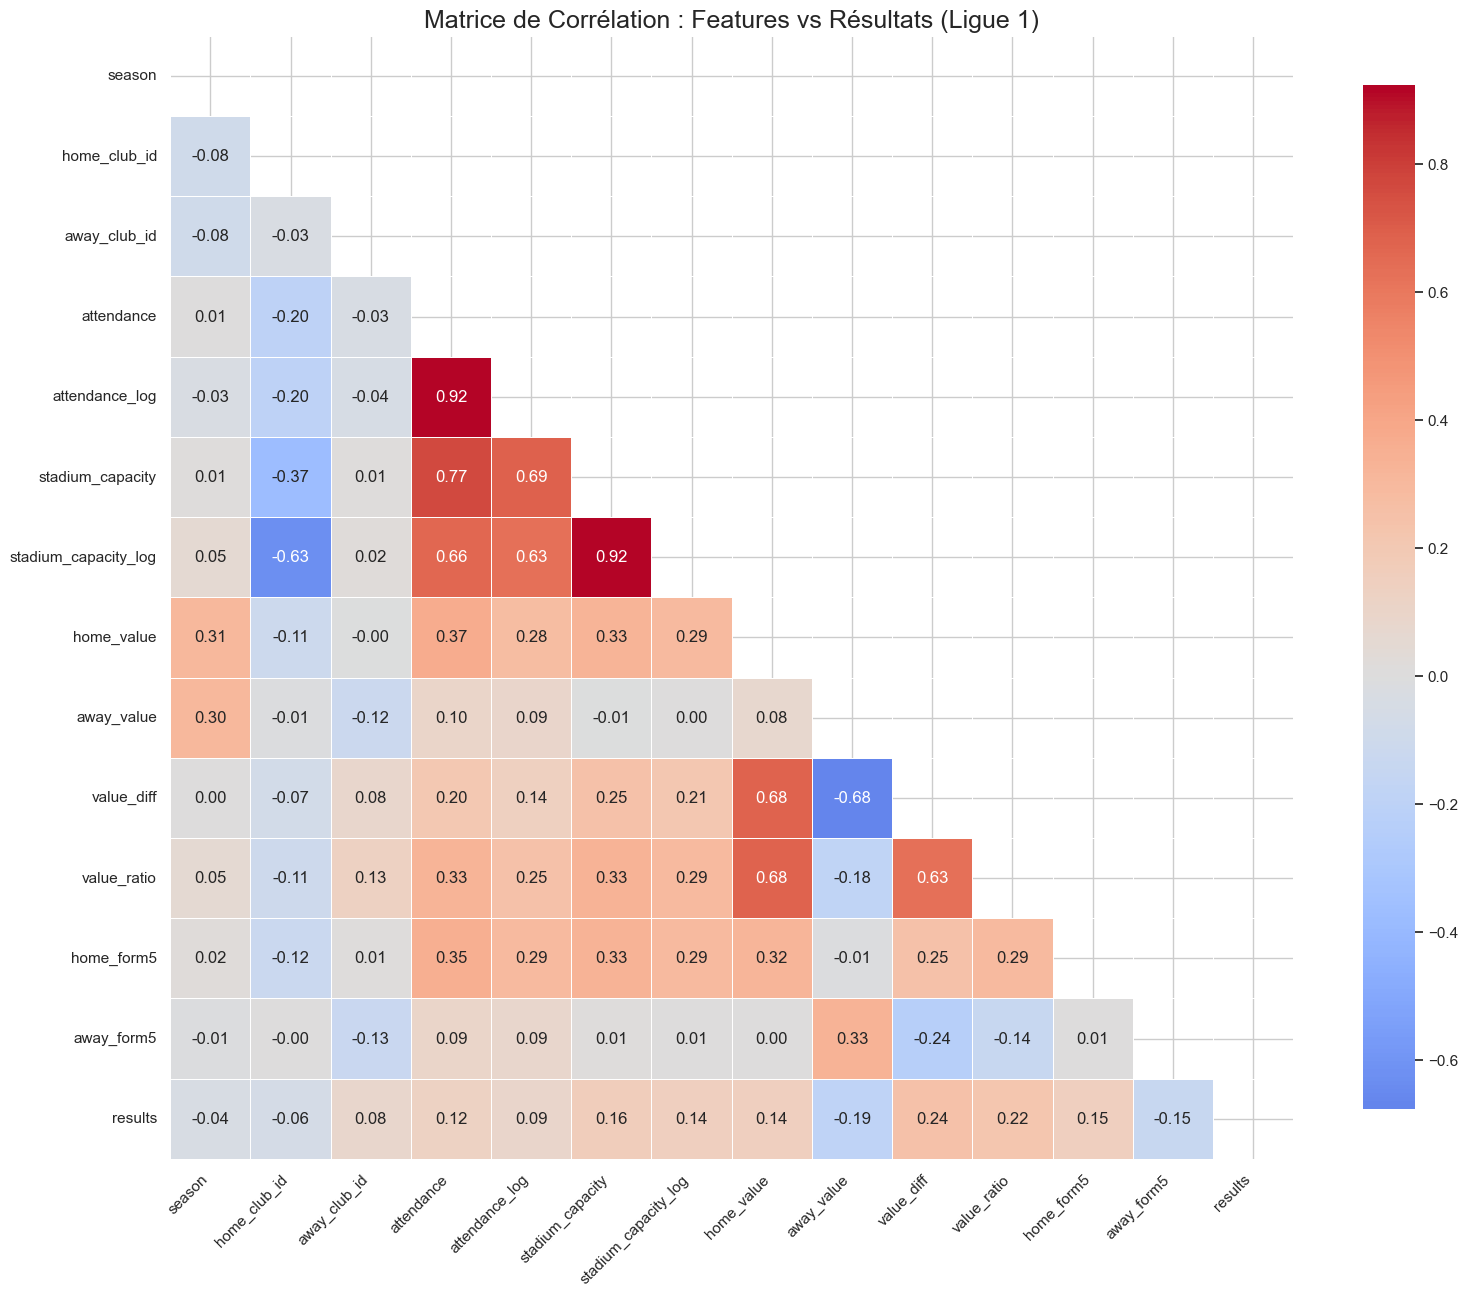

✅ Matrice de corrélation sauvegardée dans images/00_correlation_features_vs_resultats.png


In [89]:
cols_to_corr = feature_cols + ['results']

if 'game_id' in cols_to_corr:
    cols_to_corr.remove('game_id')

corr_matrix = df_train_model[cols_to_corr].corr()

plt.figure(figsize=(16, 14))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .8},
    mask=mask
)

plt.title('Matrice de Corrélation : Features vs Résultats (Ligue 1)', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

corr_path = IMAGES_DIR / '00_correlation_features_vs_resultats.png'
plt.savefig(corr_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Matrice de corrélation sauvegardée dans {corr_path}")

## Modélisation

On compare deux familles simples et robustes :
- Régression logistique multinomiale avec class_weight='balanced' + standardisation.
- RandomForest pondéré (profondeur limitée pour éviter l'overfit).

Métrique principale : F1-macro (équilibre entre classes déséquilibrées).


In [90]:
# Split temporel : train sur saisons < dernière, test sur dernière saison dispo
X = df_train_model.drop(columns=['results'])
y = df_train_model['results']

# Dernière saison disponible dans le jeu d'entraînement (ex: 2022)
last_season = df_train_model['season'].max()
train_mask = df_train_model['season'] < last_season
holdout_mask = df_train_model['season'] == last_season

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[holdout_mask]
y_test = y[holdout_mask]

print(f"Saisons train: {sorted(df_train_model.loc[train_mask, 'season'].unique())}")
print(f"Saison test (holdout): {sorted(df_train_model.loc[holdout_mask, 'season'].unique())}")
print("Shapes:", X_train.shape, X_test.shape)

# Sécurité : vérifier qu'on a bien des données dans chaque split
if X_train.empty or X_test.empty:
    raise ValueError("Split temporel vide : vérifier la colonne 'season'.")



Saisons train: [np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021)]
Saison test (holdout): [np.int64(2022)]
Shapes: (3698, 14) (380, 14)


In [91]:
def evaluate(model, X_tr, y_tr, X_te, y_te, name="model"):
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred, average='macro')
    print(f"\n{name} — Accuracy: {acc:.3f} | F1-macro: {f1:.3f}")
    print(classification_report(y_te, y_pred))
    cm = confusion_matrix(y_te, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Ext (-1)','Nul (0)','Dom (1)'],
                yticklabels=['Ext (-1)','Nul (0)','Dom (1)'])
    plt.title(f"Matrice de confusion — {name}")
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    # Sauvegarder la matrice de confusion
    filename = f"03_matrice_confusion_{name.lower().replace(' ', '_')}.png"
    plt.savefig(IMAGES_DIR / filename, dpi=300, bbox_inches='tight')
    plt.show()
    return acc, f1



LogReg balanced — Accuracy: 0.479 | F1-macro: 0.422
              precision    recall  f1-score   support

          -1       0.42      0.76      0.54       125
           0       0.28      0.13      0.18        92
           1       0.69      0.46      0.55       163

    accuracy                           0.48       380
   macro avg       0.46      0.45      0.42       380
weighted avg       0.50      0.48      0.46       380



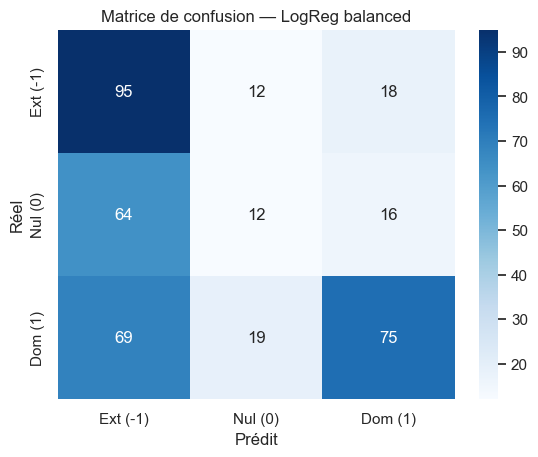

In [92]:
# Modèle 1 : Régression Logistique équilibrée
log_reg = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=800, class_weight='balanced', multi_class='multinomial')
)
log_reg.fit(X_train, y_train)
log_acc, log_f1 = evaluate(log_reg, X_train, y_train, X_test, y_test, name="LogReg balanced")



RandomForest — Accuracy: 0.484 | F1-macro: 0.419
              precision    recall  f1-score   support

          -1       0.45      0.52      0.49       125
           0       0.23      0.12      0.16        92
           1       0.57      0.66      0.61       163

    accuracy                           0.48       380
   macro avg       0.42      0.43      0.42       380
weighted avg       0.45      0.48      0.46       380



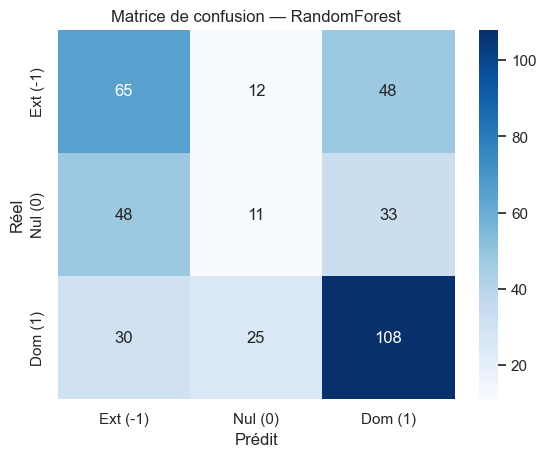

In [93]:
# Modèle 2 : RandomForest pondéré
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
rf_acc, rf_f1 = evaluate(rf, X_train, y_train, X_test, y_test, name="RandomForest")



ExtraTrees — Accuracy: 0.468 | F1-macro: 0.411
              precision    recall  f1-score   support

          -1       0.46      0.48      0.47       125
           0       0.26      0.14      0.18        92
           1       0.53      0.64      0.58       163

    accuracy                           0.47       380
   macro avg       0.42      0.42      0.41       380
weighted avg       0.44      0.47      0.45       380



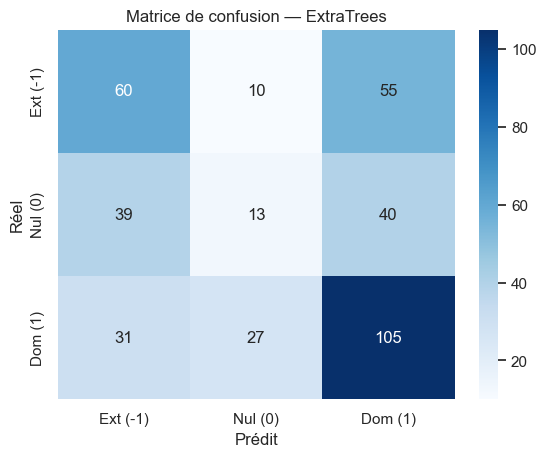

In [94]:
# Modèle 3 : ExtraTrees (forêt extrêmement aléatoire)
et_model = ExtraTreesClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

et_model.fit(X_train, y_train)
et_acc, et_f1 = evaluate(et_model, X_train, y_train, X_test, y_test, name="ExtraTrees")



GradientBoosting Simple — Accuracy: 0.416 | F1-macro: 0.414
              precision    recall  f1-score   support

          -1       0.53      0.33      0.41       125
           0       0.26      0.52      0.35        92
           1       0.57      0.42      0.49       163

    accuracy                           0.42       380
   macro avg       0.46      0.42      0.41       380
weighted avg       0.49      0.42      0.43       380



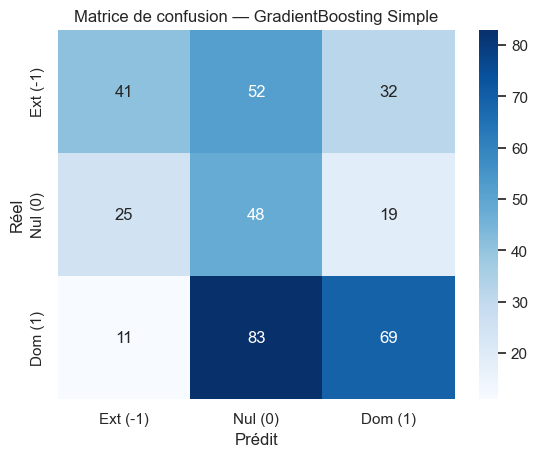

In [95]:
if XGBOOST_AVAILABLE:
    label_mapping = {-1: 0, 0: 1, 1: 2}
    reverse_mapping = {0: -1, 1: 0, 2: 1}
    
    from sklearn.base import BaseEstimator, ClassifierMixin
    from sklearn.base import clone
    import xgboost as xgb

    class XGBWrapper(BaseEstimator, ClassifierMixin):
        def __init__(self, model, label_mapping, reverse_mapping):
            self.model = model
            self.label_mapping = label_mapping
            self.reverse_mapping = reverse_mapping
        
        def fit(self, X, y):
            self.model = clone(self.model)
            y_encoded = pd.Series(y).map(self.label_mapping)
            self.model.fit(X, y_encoded)
            return self
        
        def predict(self, X):
            pred_encoded = self.model.predict(X)
            return pd.Series(pred_encoded).map(self.reverse_mapping).values
            
        def predict_proba(self, X):
            return self.model.predict_proba(X)

    # --- 2. Définition du modèle de base (Hyperparamètres fixes) ---
    xgb_base = xgb.XGBClassifier(
        random_state=42,
        objective='multi:softmax',
        num_class=3,
        eval_metric='mlogloss',
        use_label_encoder=False,
        # Paramètres fixes "standards"
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8
    )
    
    xgb_simple_model = XGBWrapper(xgb_base, label_mapping, reverse_mapping)
    xgb_simple_model.fit(X_train, y_train)
    
    xgb_simple_acc, xgb_simple_f1 = evaluate(xgb_simple_model, X_train, y_train, X_test, y_test, name="XGBoost Simple")

else:
    from sklearn.ensemble import GradientBoostingClassifier

    gb_simple_model = GradientBoostingClassifier(random_state=42,n_estimators=200,max_depth=5,learning_rate=0.1,subsample=0.8)
    
    gb_simple_model.fit(X_train, y_train)
    
    gb_simple_acc, gb_simple_f1 = evaluate(gb_simple_model, X_train, y_train, X_test, y_test, name="GradientBoosting Simple")

### Tuning (GridSearch) des modèles existants

On reprend les mêmes familles que dans le notebook initial (régression logistique et RandomForest) et on teste quelques hyperparamètres simples pour voir si on gagne sur le F1-macro.


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in ve

Best params LogReg: {'logisticregression__C': 0.1, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}

LogReg Grid — Accuracy: 0.497 | F1-macro: 0.427
              precision    recall  f1-score   support

          -1       0.42      0.74      0.53       125
           0       0.33      0.10      0.15        92
           1       0.67      0.53      0.60       163

    accuracy                           0.50       380
   macro avg       0.47      0.46      0.43       380
weighted avg       0.51      0.50      0.47       380



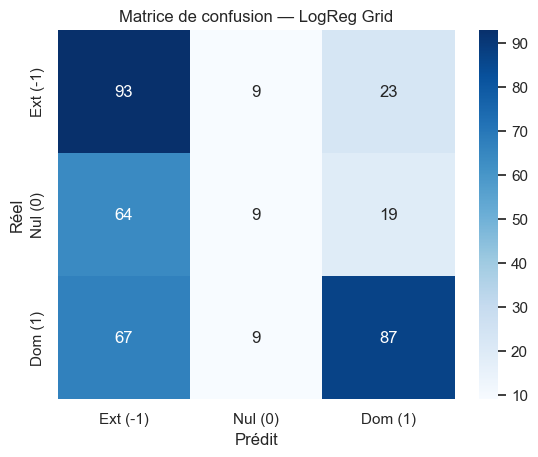

In [96]:
from sklearn.model_selection import GridSearchCV

# GridSearch Régression Logistique
log_reg_base = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, multi_class='multinomial')
)

log_param_grid = {
    'logisticregression__C': [0.1, 1, 5],
    'logisticregression__class_weight': [None, 'balanced'],
    'logisticregression__penalty': ['l2'],
    'logisticregression__solver': ['lbfgs']
}

log_gs = GridSearchCV(
    estimator=log_reg_base,
    param_grid=log_param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1
)

log_gs.fit(X_train, y_train)

print("Best params LogReg:", log_gs.best_params_)

log_gs_acc, log_gs_f1 = evaluate(log_gs.best_estimator_, X_train, y_train, X_test, y_test, name="LogReg Grid")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params RF: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 150}

Random Forest Grid — Accuracy: 0.489 | F1-macro: 0.440
              precision    recall  f1-score   support

          -1       0.47      0.56      0.51       125
           0       0.26      0.17      0.21        92
           1       0.59      0.61      0.60       163

    accuracy                           0.49       380
   macro avg       0.44      0.45      0.44       380
weighted avg       0.47      0.49      0.48       380



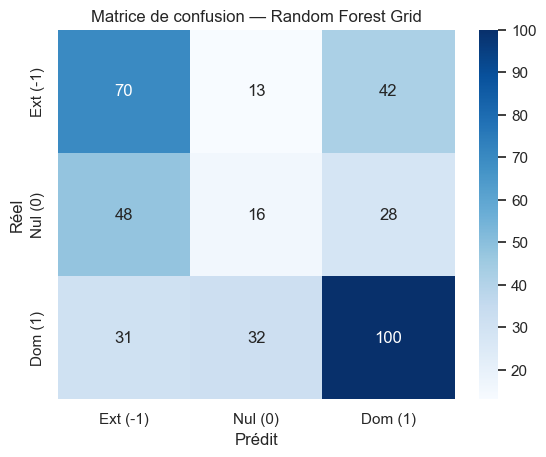

In [97]:
# GridSearch RandomForest
rf_base = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

rf_param_grid = {
    'n_estimators': [150, 300],
    'max_depth': [10, 15, None],
    'min_samples_split': [2, 5]
}

rf_gs = GridSearchCV(
    estimator=rf_base,
    param_grid=rf_param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

rf_gs.fit(X_train, y_train)

print("Best params RF:", rf_gs.best_params_)

rf_gs_acc, rf_gs_f1 = evaluate(rf_gs.best_estimator_, X_train, y_train, X_test, y_test, name="Random Forest Grid")


### Gradient Boosting / XGBoost avec GridSearch

Test du dernier modèle de la liste des pistes : Gradient Boosting (XGBoost si disponible, sinon GradientBoostingClassifier de sklearn) avec tuning des hyperparamètres et early stopping pour éviter l'overfitting.


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params GradientBoosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

GradientBoosting Grid — Accuracy: 0.442 | F1-macro: 0.433
              precision    recall  f1-score   support

          -1       0.51      0.28      0.36       125
           0       0.28      0.58      0.38        92
           1       0.65      0.49      0.56       163

    accuracy                           0.44       380
   macro avg       0.48      0.45      0.43       380
weighted avg       0.51      0.44      0.45       380



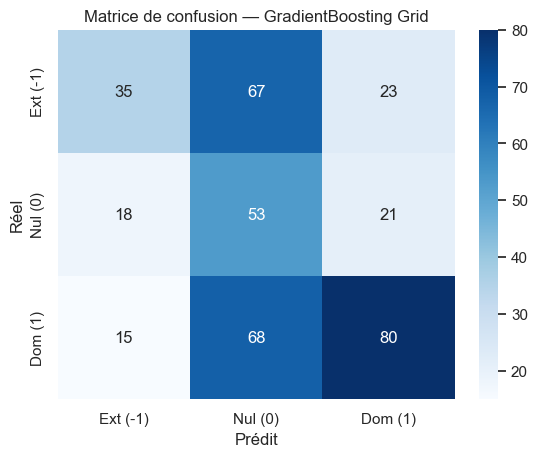

In [98]:
if XGBOOST_AVAILABLE:
    # --- 1. Préparation pour XGBoost ---
    # Encodage des labels : [-1, 0, 1] -> [0, 1, 2]
    label_mapping = {-1: 0, 0: 1, 1: 2}
    reverse_mapping = {0: -1, 1: 0, 2: 1}
    
    y_train_encoded = y_train.map(label_mapping)
    y_test_encoded = y_test.map(label_mapping)
    
    xgb_base = xgb.XGBClassifier(
        random_state=42,
        objective='multi:softmax',
        num_class=3,
        eval_metric='mlogloss',
        use_label_encoder=False
    )
    
    xgb_param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0]
    }
    
    # GridSearch
    xgb_gs = GridSearchCV(
        estimator=xgb_base,
        param_grid=xgb_param_grid,
        cv=3,
        scoring='f1_macro',
        n_jobs=-1,
        verbose=1
    )
    xgb_gs.fit(X_train, y_train_encoded)
    
    print("Best params XGBoost:", xgb_gs.best_params_)
    
    from sklearn.base import BaseEstimator, ClassifierMixin
    
    class XGBWrapper(BaseEstimator, ClassifierMixin):
        def __init__(self, model, label_mapping, reverse_mapping):
            self.model = model
            self.label_mapping = label_mapping
            self.reverse_mapping = reverse_mapping
        
        def fit(self, X, y):
            # Le modèle passé est déjà entraîné par le GridSearch
            return self
        
        def predict(self, X):
            """Prédit (0,1,2) et convertit en (-1,0,1)"""
            pred_encoded = self.model.predict(X)
            return pd.Series(pred_encoded).map(self.reverse_mapping).values
    
    xgb_grid_model = XGBWrapper(xgb_gs.best_estimator_, label_mapping, reverse_mapping)
    
    xgb_grid_acc, xgb_grid_f1 = evaluate(xgb_grid_model, X_train, y_train, X_test, y_test, name="XGBoost Grid")
    
else:
    # --- Cas GradientBoosting (sklearn) ---
    from sklearn.ensemble import GradientBoostingClassifier
    
    gb_base = GradientBoostingClassifier(random_state=42)
    
    gb_param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0]
    }
    
    gb_gs = GridSearchCV(
        estimator=gb_base,
        param_grid=gb_param_grid,
        cv=3,
        scoring='f1_macro',
        n_jobs=-1,
        verbose=1
    )
    gb_gs.fit(X_train, y_train)
    
    print("Best params GradientBoosting:", gb_gs.best_params_)
    
    gb_grid_model = gb_gs.best_estimator_
    gb_grid_acc, gb_grid_f1 = evaluate(gb_grid_model, X_train, y_train, X_test, y_test, name="GradientBoosting Grid")

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
Exception ignored in: <function ResourceTracker.__del__ at 0x104f51bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes



Ensemble Soft Voting — Accuracy: 0.492 | F1-macro: 0.451
              precision    recall  f1-score   support

          -1       0.49      0.54      0.51       125
           0       0.27      0.22      0.24        92
           1       0.59      0.61      0.60       163

    accuracy                           0.49       380
   macro avg       0.45      0.46      0.45       380
weighted avg       0.48      0.49      0.48       380



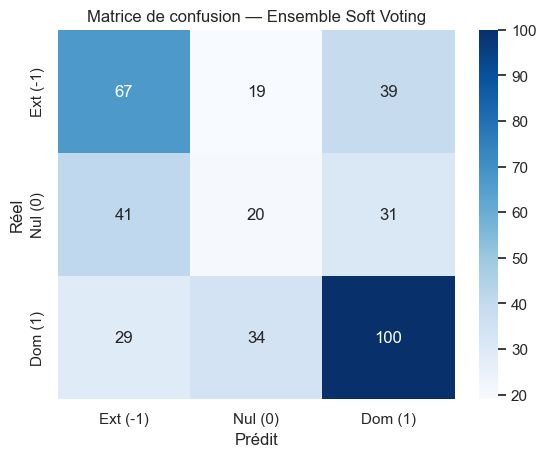

In [99]:
# Ensemble : combinaison soft-voting des meilleurs modèles disponibles
voting_estimators = []

if 'log_gs' in locals():
    voting_estimators.append(('logreg_grid', log_gs.best_estimator_))
elif 'log_reg' in locals():
    voting_estimators.append(('logreg_simple', log_reg))

if 'rf_gs' in locals():
    voting_estimators.append(('rf_grid', rf_gs.best_estimator_))
elif 'rf' in locals():
    voting_estimators.append(('rf_simple', rf))

# Boosting (XGBoost si dispo, sinon GradientBoosting)
if 'xgb_grid_model' in locals():
    voting_estimators.append(('xgb_grid', xgb_grid_model))
elif 'gb_grid_model' in locals():
    voting_estimators.append(('gb_grid', gb_grid_model))
elif 'xgb_simple_model' in locals():
    voting_estimators.append(('xgb_simple', xgb_simple_model))
elif 'gb_simple_model' in locals():
    voting_estimators.append(('gb_simple', gb_simple_model))

if 'et_model' in locals():
    voting_estimators.append(('extratrees', et_model))

if len(voting_estimators) >= 2:
    voting_clf = VotingClassifier(estimators=voting_estimators, voting='soft', n_jobs=-1)
    voting_clf.fit(X_train, y_train)
    voting_acc, voting_f1 = evaluate(voting_clf, X_train, y_train, X_test, y_test, name="Ensemble Soft Voting")
else:
    print("⚠️ Pas assez de modèles pour créer un ensemble (au moins 2 requis)")


In [100]:
results_list = []

def add_model_score(name, model, X, y):
    try:
        y_pred = model.predict(X)
        acc = accuracy_score(y, y_pred)
        f1 = f1_score(y, y_pred, average='macro')
        results_list.append({'Modèle': name, 'Accuracy': acc, 'F1-Macro': f1})
    except Exception as e:
        print(f"Pas de résultats pour {name} : {e}")

# Seulement les versions fine-tunées (Grid), ExtraTrees et Ensemble
if 'log_gs' in locals():
    model = log_gs.best_estimator_ if hasattr(log_gs, 'best_estimator_') else log_gs
    add_model_score("LogReg Grid", model, X_test, y_test)

if 'rf_gs' in locals():
    model = rf_gs.best_estimator_ if hasattr(rf_gs, 'best_estimator_') else rf_gs
    add_model_score("RandomForest Grid", model, X_test, y_test)

if 'xgb_grid_model' in locals():
    add_model_score("XGBoost Grid", xgb_grid_model, X_test, y_test)
elif 'gb_grid_model' in locals():
    add_model_score("GradientBoosting Grid", gb_grid_model, X_test, y_test)

if 'et_model' in locals():
    add_model_score("ExtraTrees", et_model, X_test, y_test)

if 'voting_clf' in locals():
    add_model_score("Ensemble Soft Voting", voting_clf, X_test, y_test)


if results_list:
    df_results = pd.DataFrame(results_list)
    
    df_results = df_results.sort_values(by='F1-Macro', ascending=False).reset_index(drop=True)
    
    df_results['Rang'] = range(1, len(df_results) + 1)
    
    df_results = df_results[['Modèle', 'Accuracy', 'F1-Macro', 'Rang']]
    
    print("\n=== TABLEAU RECAPITULATIF DES PERFORMANCES ===")
    # Formatage amélioré avec espacement des colonnes pour éviter le chevauchement
    # Créer une copie pour l'affichage
    df_display = df_results.copy()
    
    # Formater chaque colonne avec des largeurs fixes
    df_display['Modèle'] = df_display['Modèle'].apply(lambda x: f"{x:<30}")
    df_display['Accuracy'] = df_display['Accuracy'].apply(lambda x: f"{x:>12.6f}")
    df_display['F1-Macro'] = df_display['F1-Macro'].apply(lambda x: f"{x:>12.6f}")
    df_display['Rang'] = df_display['Rang'].apply(lambda x: f"{x:>6}")
    
    print(df_display.to_string(index=False))
    
    best_model_name = df_results.iloc[0]['Modèle']
    best_f1 = df_results.iloc[0]['F1-Macro']
    best_acc = df_results.iloc[0]['Accuracy']
    
    print(f"\nLE MEILLEUR MODÈLE EST : {best_model_name}")
    print(f"   -> F1-Macro : {best_f1:.4f}")
    print(f"   -> Accuracy : {best_acc:.4f}")
    
else:
    print("Aucun modèle n'a été trouvé en mémoire. Assurez-vous d'avoir exécuté les cellules d'entraînement.")


=== TABLEAU RECAPITULATIF DES PERFORMANCES ===
                        Modèle     Accuracy     F1-Macro   Rang
Ensemble Soft Voting               0.492105     0.451492      1
RandomForest Grid                  0.489474     0.440233      2
GradientBoosting Grid              0.442105     0.432919      3
LogReg Grid                        0.497368     0.426701      4
ExtraTrees                         0.468421     0.410733      5

LE MEILLEUR MODÈLE EST : Ensemble Soft Voting
   -> F1-Macro : 0.4515
   -> Accuracy : 0.4921


In [101]:
# Définition du meilleur modèle final basé sur le tableau de comparaison
if 'df_results' in locals() and len(df_results) > 0:
    best_model_name = df_results.iloc[0]['Modèle']
    
    # Mapping des noms de modèles vers les variables de modèles
    model_mapping = {
        'LogReg Simple': 'log_reg',
        'LogReg Grid': 'log_gs',
        'RandomForest Simple': 'rf',
        'RandomForest Grid': 'rf_gs',
        'XGBoost Simple': 'xgb_simple_model',
        'XGBoost Grid': 'xgb_grid_model',
        'GradientBoosting Simple': 'gb_simple_model',
        'GradientBoosting Grid': 'gb_grid_model',
        'ExtraTrees': 'et_model',
        'Ensemble Soft Voting': 'voting_clf'
    }
    
    # Récupération du modèle correspondant
    if best_model_name in model_mapping:
        model_var = model_mapping[best_model_name]
        if model_var in locals():
            if hasattr(locals()[model_var], 'best_estimator_'):
                best_model_final = locals()[model_var].best_estimator_
            else:
                best_model_final = locals()[model_var]
            print(f"✅ Meilleur modèle sélectionné : {best_model_name}")
        else:
            print(f"⚠️ Variable '{model_var}' non trouvée pour {best_model_name}")
            best_model_final = None
    else:
        print(f"⚠️ Nom de modèle non reconnu : {best_model_name}")
        best_model_final = None
else:
    print("⚠️ Tableau de comparaison non disponible")
    best_model_final = None

✅ Meilleur modèle sélectionné : Ensemble Soft Voting


In [102]:
# Importance des features pour RF/XGBoost/GradientBoosting (si choisi)
if hasattr(best_model_final, 'feature_importances_'):
    importances = pd.Series(best_model_final.feature_importances_, index=X.columns)
    plt.figure(figsize=(10,4))
    sns.barplot(x=importances.sort_values(ascending=False).head(10), y=importances.sort_values(ascending=False).head(10).index)
    model_type = "RandomForest" if isinstance(best_model_final, RandomForestClassifier) else ("XGBoost" if XGBOOST_AVAILABLE and hasattr(best_model_final, 'get_booster') else "GradientBoosting")
    plt.title(f'Top 10 importances ({model_type})')
    plt.savefig(IMAGES_DIR / '04_importance_features.png', dpi=300, bbox_inches='tight')
    plt.show()



In [103]:
# Entraînement final sur tout le jeu d'entraînement
best_model_final.fit(X, y)

# Prédictions 2023
pred_2023 = best_model_final.predict(df_predict_model)

pred_df = pd.DataFrame({
    'match_id': df_predict_model['game_id'],
    'results': pred_2023
})

output_path = DATA_DIR / 'predictions_2023.csv'
pred_df.to_csv(output_path, index=False)
print(f"Fichier de prédictions sauvegardé: {output_path}")
pred_df.head()



/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
Exception ignored in: <function ResourceTracker.__del__ at 0x106e51bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


Fichier de prédictions sauvegardé: predictions_2023.csv


,match_id,results
0,4094596,1
1,4094622,1
2,4094630,-1
3,4094647,0
4,4094696,0


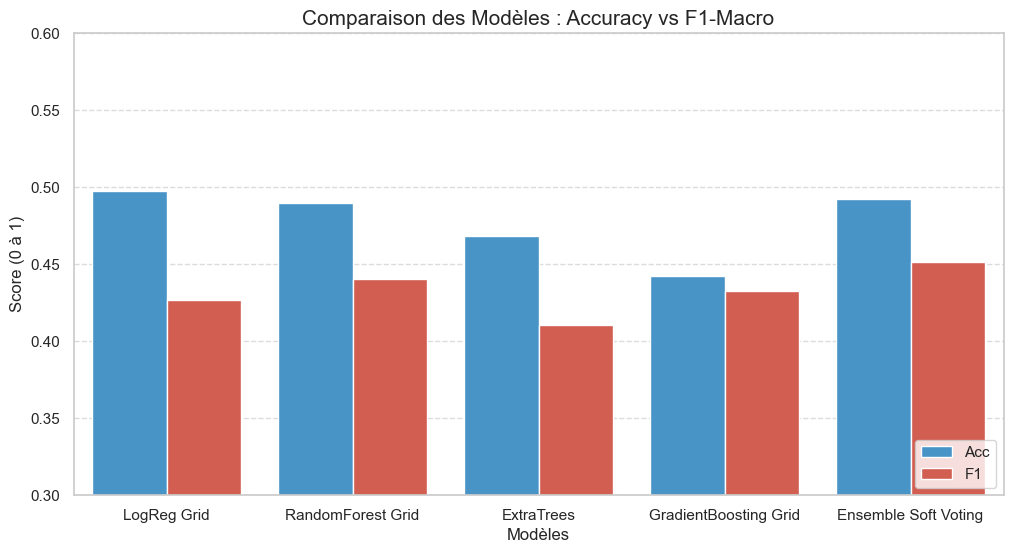

In [104]:
# 1. Récupération des scores (Seulement les versions fine-tunées, ExtraTrees et Ensemble)
model_scores = {}

if 'log_gs_acc' in locals() and 'log_gs_f1' in locals():
    model_scores['LogReg Grid'] = {'Acc': log_gs_acc, 'F1': log_gs_f1}
if 'rf_gs_acc' in locals() and 'rf_gs_f1' in locals():
    model_scores['RandomForest Grid'] = {'Acc': rf_gs_acc, 'F1': rf_gs_f1}
if 'et_acc' in locals() and 'et_f1' in locals():
    model_scores['ExtraTrees'] = {'Acc': et_acc, 'F1': et_f1}

# Ajout dynamique du Boosting Grid selon ce qui a été exécuté
if 'xgb_grid_acc' in locals() and 'xgb_grid_f1' in locals():
    model_scores['XGBoost Grid'] = {'Acc': xgb_grid_acc, 'F1': xgb_grid_f1}
elif 'gb_grid_acc' in locals() and 'gb_grid_f1' in locals():
    model_scores['GradientBoosting Grid'] = {'Acc': gb_grid_acc, 'F1': gb_grid_f1}

if 'voting_acc' in locals() and 'voting_f1' in locals():
    model_scores['Ensemble Soft Voting'] = {'Acc': voting_acc, 'F1': voting_f1}

# Création du DataFrame pour le plot
df_scores = pd.DataFrame(model_scores).T.reset_index()
df_scores = df_scores.melt(id_vars='index', var_name='Metric', value_name='Score')

# --- GRAPHIQUE 1 : Comparaison des Performances ---
plt.figure(figsize=(12, 6))
sns.barplot(data=df_scores, x='index', y='Score', hue='Metric', palette=['#3498db', '#e74c3c'])
plt.title('Comparaison des Modèles : Accuracy vs F1-Macro', fontsize=15)
plt.ylabel('Score (0 à 1)')
plt.xlabel('Modèles')
plt.ylim(0.3, 0.6) # Zoom sur la zone d'intérêt
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.savefig(IMAGES_DIR / '05_comparaison_modeles.png', dpi=300, bbox_inches='tight')
plt.show()



LogReg Grid:
  Classe -1: AUC = 0.687
  Classe 0: AUC = 0.584
  Classe 1: AUC = 0.734
  AUC macro-moyenne: 0.671

RandomForest Grid:
  Classe -1: AUC = 0.683
  Classe 0: AUC = 0.548
  Classe 1: AUC = 0.723
  AUC macro-moyenne: 0.653

GradientBoosting Grid:
  Classe -1: AUC = 0.663
  Classe 0: AUC = 0.580
  Classe 1: AUC = 0.712
  AUC macro-moyenne: 0.653

ExtraTrees:
  Classe -1: AUC = 0.652
  Classe 0: AUC = 0.523
  Classe 1: AUC = 0.668
  AUC macro-moyenne: 0.615

Ensemble Soft Voting:
  Classe -1: AUC = 1.000
  Classe 0: AUC = 1.000
  Classe 1: AUC = 1.000
  AUC macro-moyenne: 1.000


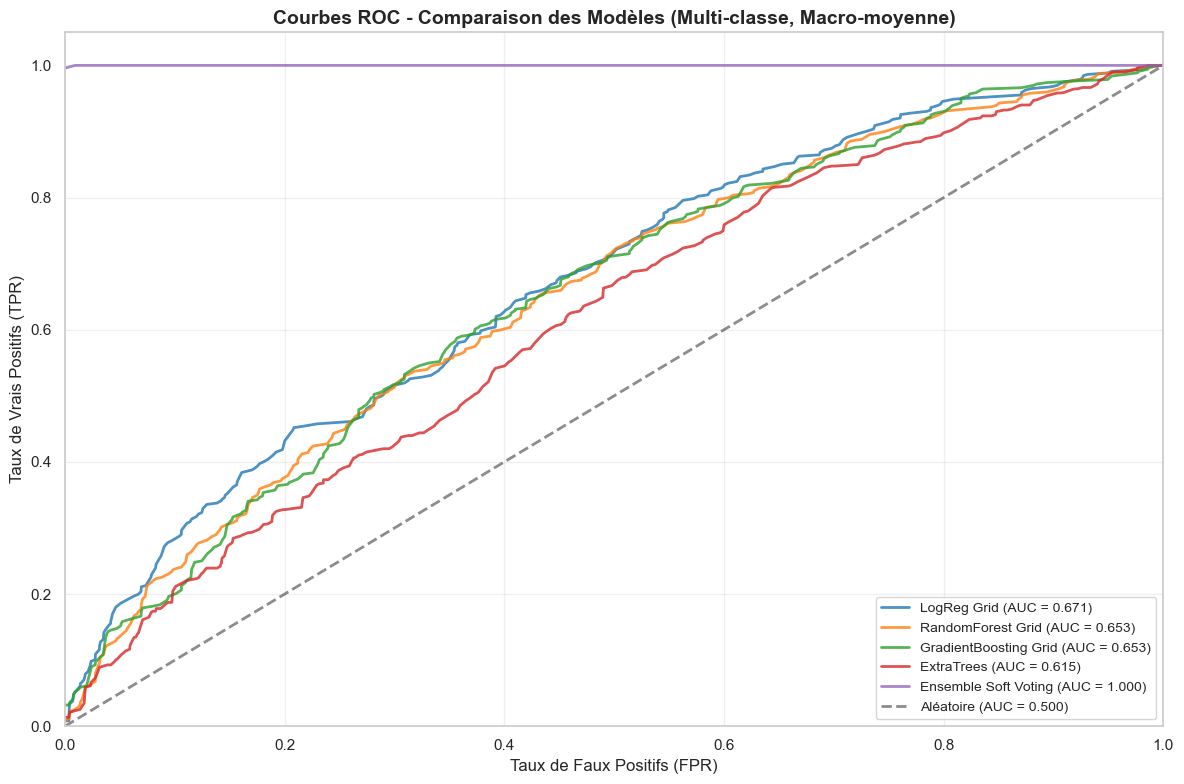


✅ Courbes ROC sauvegardées dans images/06_courbes_roc_modeles.png


In [105]:
# Courbes ROC pour tous les modèles sur un même graphique
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binariser les labels pour le multi-classe (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=[-1, 0, 1])
n_classes = 3

# Couleurs pour chaque modèle
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'])

plt.figure(figsize=(12, 8))

# Dictionnaire pour stocker les modèles et leurs noms (Seulement versions fine-tunées, ExtraTrees et Ensemble)
models_to_plot = {}

# Ajout des modèles disponibles (versions Grid uniquement)
if 'log_gs' in locals():
    models_to_plot['LogReg Grid'] = log_gs.best_estimator_ if hasattr(log_gs, 'best_estimator_') else log_gs
if 'rf_gs' in locals():
    models_to_plot['RandomForest Grid'] = rf_gs.best_estimator_ if hasattr(rf_gs, 'best_estimator_') else rf_gs
if 'xgb_grid_model' in locals():
    models_to_plot['XGBoost Grid'] = xgb_grid_model
elif 'gb_grid_model' in locals():
    models_to_plot['GradientBoosting Grid'] = gb_grid_model

if 'et_model' in locals():
    models_to_plot['ExtraTrees'] = et_model
if 'voting_clf' in locals():
    models_to_plot['Ensemble Soft Voting'] = voting_clf

# Tracer les courbes ROC pour chaque modèle
for model_name, model in models_to_plot.items():
    try:
        # Obtenir les probabilités prédites
        if hasattr(model, 'predict_proba'):
            y_score = model.predict_proba(X_test)
        else:
            print(f"⚠️ {model_name} n'a pas de méthode predict_proba, ignoré.")
            continue
        
        # Vérifier et réorganiser l'ordre des classes si nécessaire
        # Les classes attendues sont [-1, 0, 1] dans cet ordre
        if hasattr(model, 'classes_'):
            model_classes = model.classes_
            if len(model_classes) == 3:
                class_order = [-1, 0, 1]
                if not np.array_equal(model_classes, class_order):
                    # Réorganiser les colonnes de y_score
                    indices = [np.where(model_classes == c)[0][0] for c in class_order]
                    y_score = y_score[:, indices]
        
        # Pour chaque classe, calculer la courbe ROC
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Calculer la moyenne macro des courbes ROC
        # Agréger toutes les valeurs FPR
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        
        # Interpoler toutes les courbes ROC à ces points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        
        # Moyenne et normalisation
        mean_tpr /= n_classes
        
        # Calculer l'AUC moyenne (macro-average)
        mean_auc = auc(all_fpr, mean_tpr)
        
        # Tracer la courbe ROC moyenne
        color = next(colors)
        plt.plot(all_fpr, mean_tpr, 
                label=f'{model_name} (AUC = {mean_auc:.3f})',
                color=color, lw=2, alpha=0.8)
        
        # Afficher les AUC individuels pour chaque classe
        print(f"\n{model_name}:")
        for i, class_label in enumerate([-1, 0, 1]):
            print(f"  Classe {class_label}: AUC = {roc_auc[i]:.3f}")
        print(f"  AUC macro-moyenne: {mean_auc:.3f}")
        
    except Exception as e:
        print(f"⚠️ Erreur pour {model_name}: {e}")
        import traceback
        traceback.print_exc()
        continue

# Tracer la ligne de référence (aléatoire)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Aléatoire (AUC = 0.500)', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12)
plt.title('Courbes ROC - Comparaison des Modèles (Multi-classe, Macro-moyenne)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

# Sauvegarder l'image
plt.savefig(IMAGES_DIR / '06_courbes_roc_modeles.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Courbes ROC sauvegardées dans {IMAGES_DIR / '06_courbes_roc_modeles.png'}")


## 📊 Interprétation des courbes ROC et de l'AUC

### Que signifie concrètement qu'un AUC est élevé ?

**L'AUC (Area Under the ROC Curve)** mesure la **capacité du modèle à distinguer les classes** en utilisant les probabilités qu'il génère.

#### Exemple concret pour comprendre :

Imaginez que votre modèle doit prédire si un match sera :
- **Victoire domicile (1)** : probabilité = 0.75
- **Match nul (0)** : probabilité = 0.15  
- **Victoire extérieur (-1)** : probabilité = 0.10

**Si l'AUC est élevé (ex: 0.80), cela signifie :**
- Le modèle est **capable de bien séparer** les matchs selon leurs probabilités
- Quand il donne une probabilité élevée à une classe, cette classe est souvent la bonne
- Il y a une **bonne corrélation** entre les probabilités élevées et les bonnes prédictions

**Mais attention :**
- Un AUC élevé ne garantit **PAS** que le modèle fait toujours les bonnes prédictions !
- Il peut être très confiant dans ses probabilités (0.9 pour classe 1) mais se tromper quand même
- C'est pourquoi votre accuracy (0.49) peut être plus faible que l'AUC

#### Analogie simple :

Imaginez un étudiant qui :
- **AUC élevé** = Il est très confiant dans ses réponses (il sait quand il est sûr ou pas)
- **Accuracy faible** = Mais il se trompe quand même souvent dans ses réponses

### Pourquoi l'AUC peut être élevé dans votre cas ?

Pour un problème **multi-classes** (3 classes : -1, 0, 1), l'AUC est calculée en utilisant une approche **one-vs-rest** (une classe contre toutes les autres), puis on fait une moyenne macro.

**Raisons possibles d'un AUC élevé :**

1. **Déséquilibre des classes** : Si une classe est très majoritaire (comme la classe 1 avec ~45% des données), le modèle peut avoir un AUC élevé pour cette classe car il est facile de distinguer cette classe des deux autres.

2. **Problème de calcul** : Pour le multi-classes, l'AUC peut être trompeuse. Un AUC de 0.7-0.8 n'est pas exceptionnel pour un problème à 3 classes, contrairement à un problème binaire où 0.8 serait très bon.

3. **Overfitting** : Si l'AUC sur le test est beaucoup plus élevé que l'accuracy ou le F1-score, cela peut indiquer que le modèle est trop confiant dans ses probabilités, même s'il fait des erreurs de classification.

4. **Calibration des probabilités** : Les modèles comme RandomForest peuvent produire des probabilités très confiantes (proches de 0 ou 1) même quand les prédictions sont incorrectes.

### Échelle de référence pour l'AUC

- **AUC = 0.5** : Performance aléatoire (comme lancer une pièce) - Le modèle ne sait rien distinguer
- **AUC = 0.6-0.7** : Performance modeste - Le modèle distingue un peu mieux que le hasard
- **AUC = 0.7-0.8** : Performance acceptable pour multi-classes - Bonne capacité de distinction
- **AUC = 0.8-0.9** : Bonne performance - Très bonne capacité de distinction
- **AUC > 0.9** : Très bonne performance - Mais méfiez-vous de l'overfitting !

### Pourquoi regarder plusieurs métriques ?

**Important** : Pour un problème multi-classes, l'AUC macro-moyenne peut être élevée même si le modèle a des difficultés avec certaines classes (comme la classe "nul" dans votre cas). C'est pourquoi il est important de regarder aussi :

- L'**accuracy** globale (0.49 dans votre cas) : Proportion de prédictions correctes
- Le **F1-macro** (0.44 dans votre cas) : Équilibre entre précision et rappel pour toutes les classes
- Les **matrices de confusion** : Pour voir quelles classes sont mal prédites (la classe "nul" est difficile)

**En résumé** : Un AUC élevé signifie que votre modèle est **capable de bien distinguer les classes** selon les probabilités qu'il génère, mais cela ne garantit pas qu'il fait toujours les bonnes prédictions finales !


In [106]:
# Liste de toutes les images sauvegardées
print("Images sauvegardées dans le dossier 'images':")
print("-" * 50)
if IMAGES_DIR.exists():
    images = sorted(IMAGES_DIR.glob('*.png'))
    if images:
        for i, img in enumerate(images, 1):
            size_mb = img.stat().st_size / (1024 * 1024)
            print(f"{i}. {img.name} ({size_mb:.2f} MB)")
        print(f"\nTotal: {len(images)} image(s) sauvegardée(s)")
    else:
        print("Aucune image trouvée. Exécutez les cellules précédentes pour générer les images.")
else:
    print("Le dossier 'images' n'existe pas encore.")


Images sauvegardées dans le dossier 'images':
--------------------------------------------------
1. 00_correlation_features_vs_resultats.png (0.65 MB)
2. 01_distribution_cible.png (0.08 MB)
3. 02_valeurs_manquantes_attendance.png (0.20 MB)
4. 03_matrice_confusion_ensemble_soft_voting.png (0.10 MB)
5. 03_matrice_confusion_extratrees.png (0.08 MB)
6. 03_matrice_confusion_gradientboosting_grid.png (0.09 MB)
7. 03_matrice_confusion_gradientboosting_simple.png (0.09 MB)
8. 03_matrice_confusion_logreg_balanced.png (0.09 MB)
9. 03_matrice_confusion_logreg_grid.png (0.09 MB)
10. 03_matrice_confusion_random_forest_grid.png (0.10 MB)
11. 03_matrice_confusion_randomforest.png (0.09 MB)
12. 04_importance_features.png (0.11 MB)
13. 05_comparaison_modeles.png (0.13 MB)
14. 06_courbes_roc_modeles.png (0.45 MB)

Total: 14 image(s) sauvegardée(s)
